<div class="alert alert-block alert-success">
<b>NOTEBOOK 2 - Data Cleaning
</div>

---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

The same module import setup will be included in the all of the notebooks so I am not going to include any more comments on that.

In [1]:
# Centralized setup
import sys
from pathlib import Path

# Make sure PROJECT_PATH is in sys
PROJECT_ROOT = Path.cwd().resolve().parent
PROJECT_PATH = PROJECT_ROOT / "src" / "project"

if str(PROJECT_PATH) not in sys.path:
    sys.path.insert(0, str(PROJECT_PATH))

# Centralized import
from imports import *

Imports ready: pd, np, sns, plt, joblib, sklearn, etc.
PROJECT_ROOT: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project


---
# 2 - DATASET LOAD

### 2.1 - LOADING

Here I have loaded the dataset back in.

In [2]:
# Get dataset path
dataset_path = utils.get_student_csv_path()
print(dataset_path)

# Load dataset
try:
    df = utils.load_student_dataset(dataset_path)
    print('Data loaded successfully.')
except Exception as e:
    print(f'An error occurred during data loading: {e}')

C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\data\raw\student_performance_data_2025.csv
Data loaded successfully.


---
# 3 - STRUCTURAL CLEANUP

Here I am performing a **structural cleanup** which handles data without risking any leakage, as it is non-statistical. This allowes me to operate on the whole dataset (including the target) without making any distinction between train and test sets yet.

I have devised a function (see cleaning.data_quality_check()) that performed an overall quality check on the dataset. In my case, there are no date/time or free-text features so Ijust needed to check for formatting issues or other inconsistencies. 

### 3.1 - QUALITY CHECK

This function (see cleaning.data_quality_check()) scans each invidual feature and looks for potential issues with them. More specifically, it focuses on `StudyTimeWeekly`, `GPA` and `Absences` and first analyzes their ranges (and clips them if necessary based on domain knowledge and common sense). It also checks for inconsistencies (format, encoding etc...) within the numeric and categorical features. 

In [3]:
# Run quality check
df_cleaned, report = cleaning.data_quality_check(
    df,
    study_time_col="StudyTimeWeekly",
    gpa_col="GPA",
    absences_col="Absences",
    date_like_cols=["Timestamp"],  # [] or None if you have no date cols
    drop_student_id=True,
    drop_grade_class=True,
    study_time_range=(0, 100),
    remove_study_time_out_of_range=False  # keep near-zeros as signal, per your decision
)

# Print Report
cleaning.print_quality_report(report)

# Saving report
utils.save_report_md(report, "data_quality_report.md")

=== Data Quality Report ===
- dropped_columns: ['StudentID', 'GradeClass']
- study_time:
  - non_numeric_coerced: 0
  - min: 0.001056538645936
  - max: 19.97809399526153
  - out_of_range:
    - count: 0
    - range_used: [0, 100]
- gpa:
  - non_numeric_coerced: 0
  - min: 0.0
  - max: 4.0
- absences:
  - non_numeric_coerced: 0
  - min: 0.0
  - max: 29.0
  - negative_count: 0
  - upper_outliers: 0
  - upper_fence: 44.5
- date_columns:
  - StudyTimeWeekly:
    - parse_success_rate: 1.0
    - future_dates: 0
- categorical_format_inconsistencies: ok
- encoding_issues: ok
Report saved to: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\outputs\reports\data_quality_report.md


C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\src\data\cleaning.py:191: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(out[c], errors="coerce", utc=False, infer_datetime_format=True)


WindowsPath('C:/Users/Vaccari/Desktop/iCloudDrive/Desktop/ENRICO/05_LEARNING/University/ToU/Phases/02_Calibration_Phase/Applied_Machine_Learning/Regression/beyond-grades-ml-project/outputs/reports/data_quality_report.md')

### 3.2 - CHECK TYPES

I have then assigned the right types to the available features as follows. 

In [ ]:
# Fixing Types

# Categorical
categorical_cols = [
    "Gender", "Ethnicity", "ParentalEducation", "Tutoring",
    "ParentalSupport", "Extracurricular", "Sports",
    "Music", "Volunteering"
]

for col in categorical_cols:
    df_cleaned[col] = df_cleaned[col].astype("category")

# Numeric
numeric_cols = []
for col in df_cleaned.columns:
    if col not in categorical_cols:
        numeric_cols.append(col)
        
# Print
print("Numeric columns: "+ str(numeric_cols))
print("Categorical columns: "+ str(categorical_cols))

df_cleaned.info()

Numeric columns: ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
Categorical columns: ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   int64   
 1   Gender             2392 non-null   category
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   category
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   category
 9   Sports             2392 non-null   category
 10  Music              2392 non-null   category
 11  Volunteering       2392 non-null   ca

### 3.3 - HARD CLIPPING

While exploring the relationship between **StudyTimeWeekly** and **GPA**, I noticed that some students reported extremely low study times (values close to 0). At first glance, these could appear as potential noise or measurement errors.  

However, based on the context of the dataset, it seems likely that study time is tracked **automatically by the system/app** rather than being self-reported.  
This means that very small values (a few seconds or minutes) may reflect students who only **logged in briefly**, opened the app, and closed it.  

- These students still attempted the test or engaged minimally, so removing them entirely could bias the analysis.  
- Their **low GPA scores** are consistent with the interpretation that minimal study time corresponds to weaker performance.  
- To highlight the potential distinction, I plotted a **threshold at 1 hour** of weekly study time, comparing GPA distributions above vs below this cutoff.  

> **Decision:** I decided **not to hard-clip** these values, since they likely represent real behavior. Instead, they will be retained in the dataset, with the awareness that they correspond to a specific subgroup of students (very low app engagement).

I made use of some functions stored in analysis.py to make my final decision.


2011    0.001057
949     0.004859
87      0.008031
1330    0.008206
619     0.014337
556     0.015790
2262    0.018117
406     0.025689
738     0.046949
1304    0.060417
1230    0.074393
1697    0.087192
1776    0.106484
546     0.106980
2310    0.112626
2003    0.115413
1004    0.135763
2219    0.162164
398     0.167094
693     0.169030
686     0.184018
1504    0.184832
2220    0.185050
54      0.186206
1415    0.190779
1718    0.194007
1076    0.213403
1808    0.227793
1247    0.230520
1787    0.232898
Name: StudyTimeWeekly, dtype: float64


C:\Users\Vaccari\AppData\Local\Temp\ipykernel_97500\1138006242.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="StudyTimeThreshold", y="GPA", data=df_cleaned, palette="Set2")


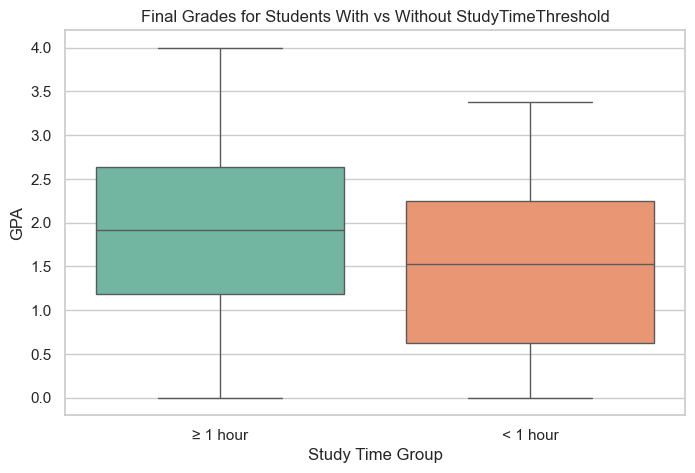

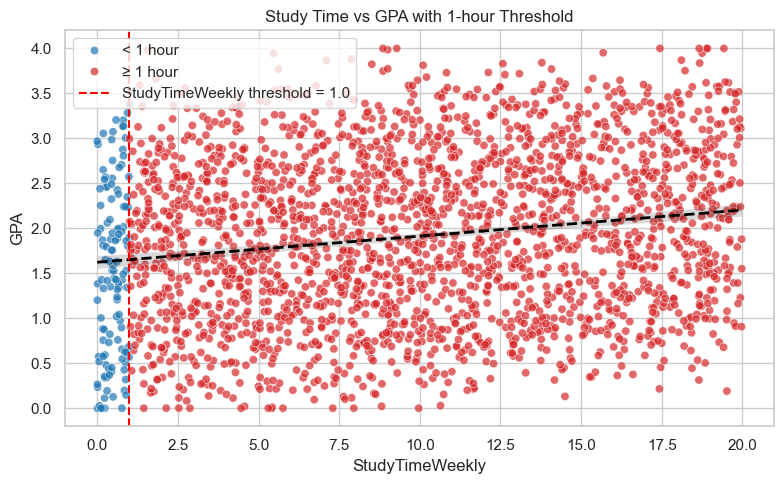

In [8]:
# Check 30 lowest "StudyTimeWeekly" values
lowest_30 = df_cleaned["StudyTimeWeekly"].nsmallest(30)
print(lowest_30)


# Define threshold for StudyTimeThreshold
threshold = 1  # hour
df_cleaned["StudyTimeThreshold"] = (df_cleaned["StudyTimeWeekly"] < threshold).astype(int)

# Plot distribution of grades split by StudyTimeThreshold
plt.figure(figsize=(8,5))
sns.boxplot(x="StudyTimeThreshold", y="GPA", data=df_cleaned, palette="Set2")

plt.xticks([0,1], ["≥ 1 hour", "< 1 hour"])
plt.xlabel("Study Time Group")
plt.ylabel("GPA")
plt.title("Final Grades for Students With vs Without StudyTimeThreshold")
plt.show()

# Plot StudyTimeWeekly (with 1 hour threshold) against GPA
analysis.scatter_with_auto_threshold(
    df_cleaned,
    x="StudyTimeWeekly", y="GPA",
    threshold=1.0, axis="x",
    make_groups=True,
    left_label="< 1 hour",
    right_label="≥ 1 hour",
    title="Study Time vs GPA with 1-hour Threshold"
)

During the **structural cleanup phase**, the dataset was examined for a series of common quality issues.  
All of the following checks were performed:

- **Duplicates** → none found.  
- **Obvious errors / impossible values** → none detected.  
- **Encoding errors** → not present.  
- **Wrong units** → no inconsistencies identified.  
- **Format inconsistencies** → none observed across columns.  
- **Future dates / date issues** → not applicable, no datetime fields in this dataset.  
- **Text standardization** → not needed (no free-text fields).  
- **Datetime formatting** → not applicable.  

> These checks confirm that the dataset did not require structural corrections for these categories.  
> Most of these issues were either **handled beforehand** during data collection or are **not applicable** to this dataset (e.g., absence of text/date fields).


In [6]:
# Save dataset
utils.save_dataset(df_cleaned, 'interim/01_dataset_structural_cleanup.xlsx')

File saved at: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\data\interim\01_dataset_structural_cleanup.xlsx


In [7]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   int64   
 1   Gender             2392 non-null   category
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   category
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   category
 9   Sports             2392 non-null   category
 10  Music              2392 non-null   category
 11  Volunteering       2392 non-null   category
 12  GPA                2392 non-null   float64 
dtypes: category(9), float64(2), int64(2)
memory usage: 97.2 KB


<div class="alert alert-block alert-info">
<b>Next Notebook - Data Splitting
</div>